In [ ]:
pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
# Function for setting the seed
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Loading and Data Preparation:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load data
train_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/train.csv')

# Separate the dataset into features (pixel values) and labels
labels = train_data['label']
pixels = train_data.drop('label', axis=1) / 255.0  # Normalize pixel values

# Check shapes
print("Check shapes:", labels.shape, pixels.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Check shapes: (42000,) (42000, 784)


## Get unique class names

In [ ]:
class_names = sorted(labels.unique())
print("Class Names:", class_names)

Class Names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Split the data

In [ ]:
# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42)

# Reshape data for CNN
X_train = np.array(X_train).reshape(-1, 1, 28, 28)
X_val = np.array(X_val).reshape(-1, 1, 28, 28)

## Transform data acceptable to CNN algoritm

In [ ]:
# Convert data to tensors and create dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long).to(device)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Output to confirm loaders are created
print("Train and validation loaders created:")
print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))

Train and validation loaders created:
Train loader size: 525
Validation loader size: 132


## CNN model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize model
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Define loss function, optimizer and custom accurancy metric

In [ ]:
# Initialize loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# custom accuracy
def accuracy_fn(y_true, y_pred):
    return MulticlassAccuracy(num_classes=len(class_names))(preds=y_pred, target=y_true)

#   Train the model

In [ ]:
# Initialize lists to track training and validation accuracies
train_accuracies = []
val_accuracies = []

# Training and validation loop with accuracy tracking
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

# Final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1, Training Accuracy: 90.72%, Validation Accuracy: 95.93%
Epoch 2, Training Accuracy: 96.74%, Validation Accuracy: 97.31%
Epoch 3, Training Accuracy: 97.90%, Validation Accuracy: 97.94%
Epoch 4, Training Accuracy: 98.37%, Validation Accuracy: 97.73%
Final Validation Accuracy: 97.73%


Test Accuracy: 98.64%

# Vizualize train and test progress over epochs

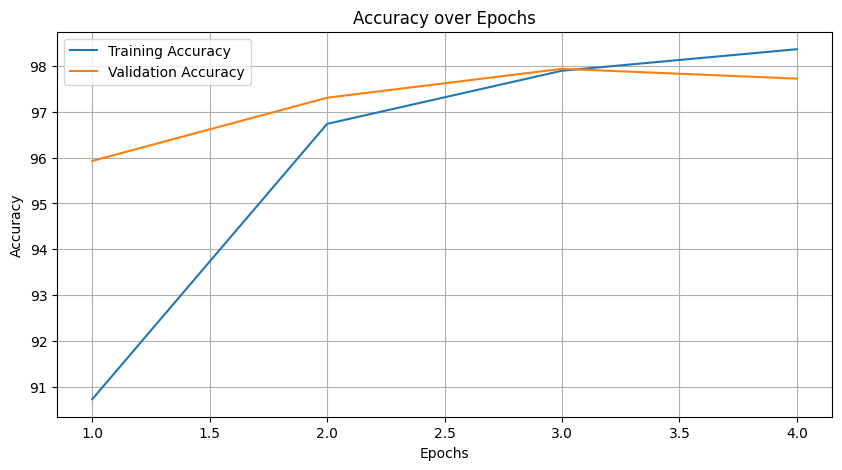

In [ ]:
# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
labels = train_data['label']


In [ ]:
labels.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

# FINAL TRAIN on full test data

In [ ]:
# Load data
train_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/train.csv')

# Separate the dataset into features (pixel values) and labels
labels = train_data['label']
pixels = train_data.drop('label', axis=1) / 255.0  # Normalize pixel values

# Check shapes
print("Check shapes:", labels.shape, pixels.shape)

Check shapes: (42000,) (42000, 784)


In [ ]:
# create new model and new optimizer
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# transform train data
X = np.array(pixels).reshape(-1, 1, 28, 28)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)

y = labels
y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)  # Ensure labels are long type for CrossEntropyLoss

# Create the dataset and data loader
X_dataset = TensorDataset(X_tensor, y_tensor)
X_loader = DataLoader(X_dataset, batch_size=64, shuffle=True)

# Retrain on all train data
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in X_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} complete')


Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete


# TEST

Prepare the Test Data:
Similar to how you prepared your training and validation datasets, you need to prepare your test dataset. Load the test data and preprocess it accordingly.

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/test.csv')

test_pixels = test_data / 255.0  # Нормалізація
test_pixels = np.array(test_pixels).reshape(-1, 1, 28, 28)  # transform for CNN

# Convert NumPy arrays to PyTorch tensors
X_test_tensor = torch.tensor(test_pixels, dtype=torch.float32)

# Assuming y_test_tensor contains the true labels
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [ ]:
# eval mode
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

In [ ]:
pred_probs = []
model.eval()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)  # Move input tensor to GPU

        # Move the model to the GPU
        model = model.to(device)

        # Forward pass (model outputs raw logit)
        pred_logit = model(inputs)

        # Get prediction probability (logit -> prediction probability)
        pred_prob = torch.softmax(pred_logit, dim=1)

        # Append the prediction probabilities to the list
        pred_probs.append(pred_prob.cpu().numpy())

# Convert the list of prediction probabilities to a NumPy array
pred_probs_array = np.concatenate(pred_probs, axis=0)


In [ ]:
pred_probs_array

array([[9.6721340e-07, 7.1648125e-11, 9.9999499e-01, ..., 5.5490347e-07,
        2.1939159e-06, 1.6812106e-07],
       [9.9998403e-01, 1.1769481e-08, 1.6011212e-06, ..., 2.3597795e-06,
        1.7334186e-08, 1.8226105e-07],
       [1.4830098e-07, 1.1740511e-06, 3.0717094e-04, ..., 1.1555814e-04,
        2.4307484e-03, 9.9623626e-01],
       ...,
       [2.1876915e-13, 9.3765884e-11, 5.0096993e-10, ..., 1.9782694e-10,
        1.1202249e-06, 4.9082983e-06],
       [4.0926551e-07, 1.7363287e-09, 1.6060078e-08, ..., 8.2014467e-06,
        9.5300538e-06, 9.9886835e-01],
       [5.3493554e-08, 4.2714166e-11, 9.9999344e-01, ..., 2.0004489e-08,
        5.9824474e-06, 2.1753688e-07]], dtype=float32)

In [ ]:
predicted_labels = np.argmax(pred_probs_array, axis=1)
predicted_labels

array([2, 0, 9, ..., 3, 9, 2])

# SUBMISSION

In [ ]:
sample_data = pd.read_csv('/content/drive/MyDrive/Digit_recogn/sample_submission.csv')

In [ ]:
sample_data['Label'] = predicted_labels
sample_data

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
sample_data.to_csv('/content/drive/MyDrive/Digit_recogn/sample_submission_digit.csv', index=False)

**rank 962/1833**

https://www.kaggle.com/competitions/digit-recognizer/submissions

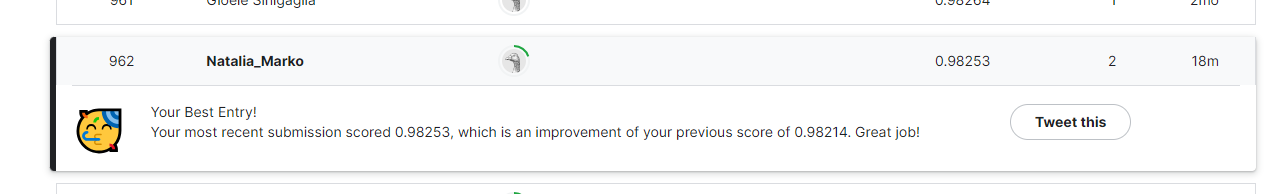